In [70]:
import qpms
import numpy as np
from matplotlib import pyplot as plt
import scipy
from scipy import interpolate
from scipy.constants import e as eV, hbar
ň = np.newaxis

In [37]:
TMatrix_file = '/u/46/necadam1/unix/tmatrix-experiments/Cylinder/hexlasingPaper/cylinder_50nm_lMax2_long.TMatrix'
Wfile = '/l/deep_dispdata/fulls'
#Wfile = '/u/46/necadam1/unix/qpms/qpms/apps/test/3out'
Wfile_long = '/l/deep_dispdata/longs'
Wfile_short = '/l/deep_dispdata/shorts'


In [38]:
#wdata = qpms.loadWfile(Wfile)
#wdata = qpms.loadWfile(Wfile_long)
wdata_short = qpms.loadWfile(Wfile_short)
wdata_long = qpms.loadWfile(Wfile_long)
TMatrices_orig, freqs_orig, freqs_weirdunits_orig, lMaxTM = qpms.loadScuffTMatrices(TMatrix_file, normalisation = 2, version = 'new')

In [39]:
lMax = lMaxTM 
npart = 2
nelem = qpms.get_nelem(lMax)
nomega = 400 # 286
nk = 150 #100

In [40]:
#symmetrize TMatrices
yfl = qpms.yflip_tyty(lMax)
xfl = qpms.xflip_tyty(lMax)
zfl = qpms.zflip_tyty(lMax)
TMatrix=TMatrices_orig
TMatrix_sym = (TMatrix + qpms.apply_ndmatrix_left(yfl,qpms.apply_ndmatrix_left(yfl, TMatrix, (-4,-3)),(-2,-1)))/2
TMatrix_sym = (TMatrix_sym + qpms.apply_ndmatrix_left(xfl,qpms.apply_ndmatrix_left(xfl, TMatrix_sym, (-4,-3)),(-2,-1)))/2
TMatrix_sym = (TMatrix_sym + qpms.apply_ndmatrix_left(zfl,qpms.apply_ndmatrix_left(zfl, TMatrix_sym, (-4,-3)),(-2,-1)))/2
rotN = 600

TMatrix_contribs = np.empty((rotN,)+TMatrix.shape, dtype=np.complex_)
for i in range(rotN):
    rotangle = 2*np.pi*i / rotN
    rot =  qpms.WignerD_yy_fromvector(lMax,np.array([0,0,rotangle]))
    rotinv = qpms.WignerD_yy_fromvector(lMax,np.array([0,0,-rotangle]))
    TMatrix_contribs[i] = qpms.apply_matrix_left(rot,qpms.apply_matrix_left(rotinv, TMatrix_sym, -3),-1)
TMatrix_sym = np.sum(TMatrix_contribs, axis=0) / rotN
TMatrix_sym[np.abs(TMatrix_sym) <= 1e-16] = 0

In [41]:
# TODO process (interpolate and symmetrize) T-matrix here
TMatrices_interp = interpolate.interp1d(freqs_orig, TMatrix_sym, axis = 0, kind='linear', fill_value='extrapolate')


In [56]:
#Wmatrices = wdata['Ws'].reshape((nomega,nk,npart,2,nelem,npart,2,nelem))
Wmatrices = (wdata_long['Ws']+0*wdata_short['Ws']).reshape((nomega,nk,npart,2,nelem,npart,2,nelem))
#TMatrices = TMatrix_sym.reshape((nomega,1,2,nelem,2,nelem))
ks = wdata['ks'].reshape((nomega,nk,2))
freqs = wdata['freqs'].reshape((nomega,nk))
Wmatrices.shape, ks.shape

((400, 150, 2, 2, 8, 2, 2, 8), (400, 150, 2))

In [57]:
TMatrices_orig.shape, ks.shape, freqs.shape

((286, 2, 8, 2, 8), (400, 150, 2), (400, 150))

In [58]:
freqs_weirdunits_orig[-1]

7.365

In [59]:
allU = np.full((nomega,nk,npart*2*nelem,npart*2*nelem), np.nan, dtype=complex)
allV = np.full((nomega,nk,npart*2*nelem,npart*2*nelem), np.nan, dtype=complex)
allS = np.full((nomega,nk,npart*2*nelem), np.nan)

In [60]:
for omi in range(nomega):
    for ki in range(nk):
        W = Wmatrices[omi,ki]
        T = TMatrices_interp(freqs[omi,ki]) #* 10
        TW = np.sum(
            T[...,ň,:,:,:,:,ň,ň,ň] * W[...,:,ň,ň,:,:,:,:,:]
        , axis = (-5,-4))
        iden = np.eye(npart*2*nelem)
        iden.shape = (npart,2,nelem,npart,2,nelem)
        finalMatrix = iden-TW
        try:
            allU[omi,ki], allS[omi,ki], allV[omi,ki] = scipy.linalg.svd(finalMatrix.reshape((npart*2*nelem,npart*2*nelem)))
        except ValueError:
            pass
                

In [61]:
allS[2,59]

array([1.00116943, 1.00086268, 1.00067849, 1.00063819, 1.00032877,
       1.00030481, 1.00028014, 1.00023514, 1.00022954, 1.00011242,
       1.00011043, 1.00004612, 1.00000232, 1.00000088, 1.00000078,
       1.00000056, 0.9999997 , 0.99999715, 0.99999397, 0.99999094,
       0.99996123, 0.99995993, 0.99995914, 0.9999508 , 0.99994906,
       0.99990941, 0.99913729, 0.99832161, 0.99808182, 0.99759514,
       0.99751018, 0.99538009])

In [62]:
wdata['freqs_weirdunits'].reshape((nomega, nk))[110,85]
ks[110,85]

array([      0., 4203500.])

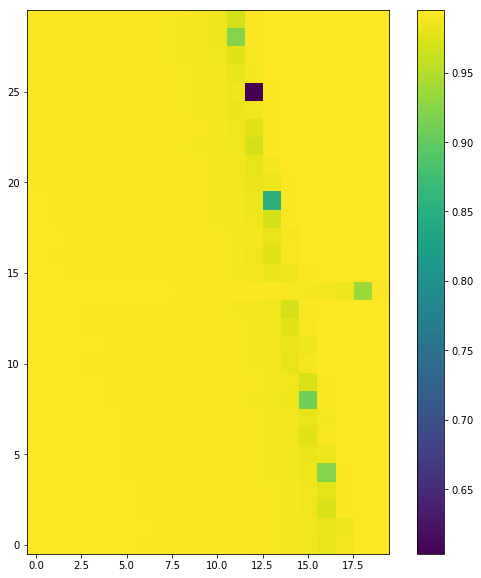

In [63]:
#full
plt.figure(figsize=(10,10))
plt.imshow(allS[85:115,90:110,-1], origin = 'lower')
plt.colorbar()

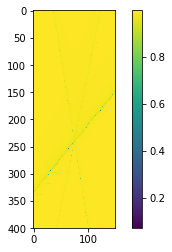

In [64]:
#short
plt.imshow(allS[:,:,-1])
plt.colorbar()

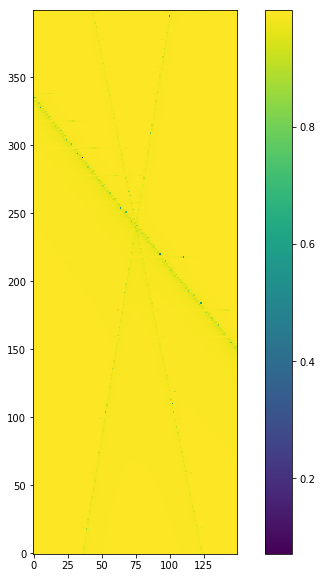

In [65]:
%matplotlib inline
#long
plt.figure(figsize=(10,10))
plt.imshow(allS[:,:,-1], origin = 'lower')
plt.colorbar()

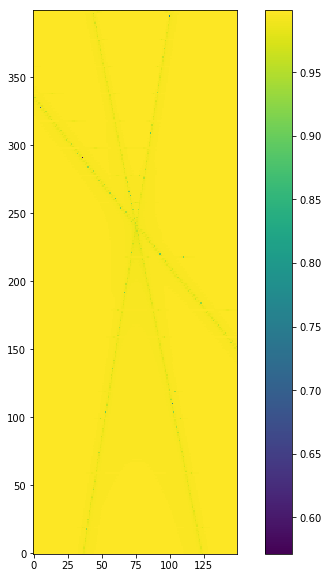

In [66]:
%matplotlib inline
#full
plt.figure(figsize=(10,10))
plt.imshow(allS[:,:,-3], origin = 'lower')
plt.colorbar()

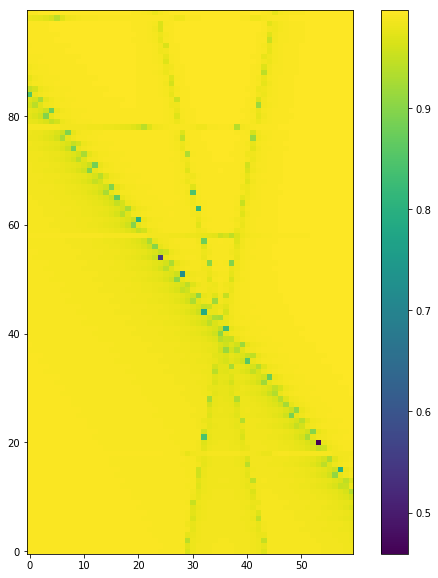

In [67]:
plt.figure(figsize=(10,10))
plt.imshow(allS[200:300,40:100,-1], origin = 'lower')
plt.colorbar()

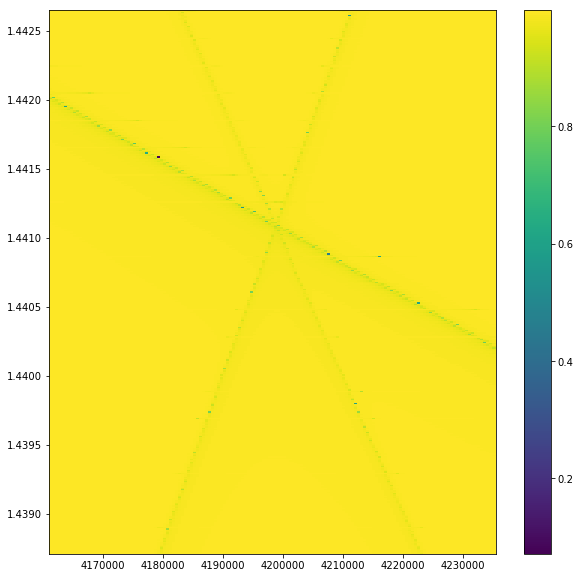

In [71]:
plt.figure(figsize=(10,10))
plt.pcolormesh(ks[:,:,1], freqs[:,:]*hbar/eV, allS[:,:,-1])
plt.colorbar()